In [9]:
import struct
import os
import numpy as np
import matplotlib.pyplot as plt
import requests, gzip, os, hashlib
from scipy.special import expit 
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


# Код загрузки данных

In [2]:
def downloader(url):
    path = os.getcwd()
    fp = os.path.join(path, hashlib.md5(url.encode('utf-8')).hexdigest())
    if os.path.isfile(fp):
        with open(fp, "rb") as f:
            data = f.read()
    else:
        with open(fp, "wb") as f:
            data = requests.get(url).content
            f.write(data)
    return np.frombuffer(gzip.decompress(data), dtype=np.uint8).copy()

In [3]:
def normalize(X):
    return 2.*(X/255.-0.5)

def get_data(norm, one_hot):    
    # Скачивание данных
    img_train = downloader("http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
    lbl_train = downloader("http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz")[8:]
    img_test = downloader("http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28*28))
    lbl_test = downloader("http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz")[8:]

    # Нормализация данных
    if norm:
        img_train, img_test = normalize(img_train), normalize(img_test)

    # Reshape images to vectors
    n_input = img_train.shape[-1]**2
    img_train, img_test = img_train.reshape(len(img_train), n_input), img_test.reshape(len(img_test), n_input)

    # Compute one-hot labels
    n_classes = len(np.unique(lbl_train))
    if one_hot:
        lbl_train = np.eye(n_classes)[lbl_train]
        lbl_test = np.eye(n_classes)[lbl_test]

    # Split evaluation dataset from training dataset
    prop = 0.95 # 5% of training data will be used for evaluation
    split_idx = int(prop*len(img_train))
    img_eval, lbl_eval = img_train[split_idx:], lbl_train[split_idx:]
    img_train, lbl_train = img_train[:split_idx], lbl_train[:split_idx]

    return img_train, lbl_train, img_eval, lbl_eval, img_test, lbl_test, n_classes, n_input

# Функции активации и инициализации

In [4]:
# Сигмоида
def sigma(x):
    return expit(x)

# Производная сигмоиды
def sigma_prime(x):
    u = sigma(x)
    return u*(1-u)

# Релу
def relu(x):
    return x*(x>0)

# Производня релу
def relu_prime(x):
    return (x>0)

# kaiming initialization
def kaiming(network_config, l):
    return np.random.normal(size=(network_config[l+1], network_config[l])) * np.sqrt(2./network_config[l])

# MLP - класс нейронной сети

In [18]:
class NeuralNetwork(object):

    def __init__(self, network_config):
        self.n_layers = len(network_config)
        # Веса
        self.W = [kaiming(network_config, l) for l in range(self.n_layers-1)]
        # Баес
        self.b = [np.zeros((network_config[l], 1)) for l in range(1, self.n_layers)]
        # Пре-активация
        self.z = [None for l in range(1, self.n_layers)]
        # Активация
        self.a = [None for l in range(self.n_layers)]
        # Градиенты
        self.dW = [None for l in range(self.n_layers-1)] 
        self.db = [None for l in range(1, self.n_layers)]
        # 
        self.test_losses = []
        self.test_accuracy = []
        self.valid_losses = []
        self.valid_accuracy = []


    def grouped_rand_idx(self, n_total, batch_size):
        idx = np.random.permutation(n_total)
        return [idx[i:i+batch_size] for i in range(0, len(idx), batch_size)]

    def optimize(self, x_train, y_train, x_valid, y_valid, x_test, y_test, epochs, batch_size, learning_rate):
        eta = learning_rate / batch_size
        for epoch in range(epochs):

            if epoch % 1 == 0:
                self.prediction(x_valid, y_valid, epoch, mode="valid")

            if epoch % 10 == 0:
                self.visualize_weights(epoch)

            idx_list = self.grouped_rand_idx(len(x_train), batch_size)
            for idx in idx_list:
                # Возьмем батч
                x_batch, y_batch = x_train[idx], y_train[idx]
                self.feedforward(x_batch) 
                self.backprop_gradient_descent(y_batch, eta)

        self.visualize_weights(epoch+1)
        self.prediction(x_valid, y_valid, epoch+1, mode="valid")
        # Посчитаем точность и лосс
        self.prediction(x_test, y_test, epoch+1, mode="test")

    def backprop_gradient_descent(self, Y, eta):
        delta = (self.a[-1] - Y) * sigma_prime(self.z[self.n_layers-2])
        self.dW[self.n_layers-2] = np.matmul(delta.T, self.a[self.n_layers-2])
        self.db[self.n_layers-2] = np.sum(delta.T, axis=1, keepdims=True)

        for l in reversed(range(self.n_layers-2)):
            delta = np.matmul(delta, self.W[l+1]) * relu_prime(self.z[l])
            self.dW[l] = np.matmul(self.a[l].T, delta).T
            self.db[l] = np.sum(delta.T, axis=1, keepdims=True)

        for l in range(self.n_layers-1):
            self.W[l] -= eta * self.dW[l]
            self.b[l] -= eta * self.db[l]

        self.dW = [None for l in range(self.n_layers-1)]
        self.db = [None for l in range(self.n_layers-1)]

    def feedforward(self, X):
        self.a[0] = X 
        for l in range(self.n_layers-2):
            self.z[l] = np.matmul(self.a[l], self.W[l].T) + self.b[l].T     
            self.a[l+1] = relu(self.z[l])                                  
        self.z[-1] = np.matmul(self.a[-2], self.W[-1].T) + self.b[-1].T     
        self.a[-1] = sigma(self.z[-1])                                      

    def pred(self, X, Y):
        neurons = X
        for l in range(self.n_layers-2):
            neurons = relu(np.matmul(neurons, self.W[l].T) + self.b[l].T)
        logits = np.matmul(neurons, self.W[-1].T) + self.b[-1].T
        accuracy = (np.argmax(logits, axis=1) == np.argmax(Y, axis=1)).sum() / len(X)
        loss = np.sum((Y - sigma(logits))**2) / len(X)
        return loss, accuracy

    def prediction(self, X, Y, epoch, mode):
        loss, accuracy = self.pred(X, Y)
        if mode == "valid":
            self.valid_losses.append(loss)
            self.valid_accuracy.append(accuracy)   
        print('epoch {1} {0}_loss {2:.6f} {0}_accuracy {3:.4f}'.format(mode, epoch, loss, accuracy), flush=True)

    def visualize_weights(self, epoch):
        nrow, ncol = 11, 11
        fig, axes = plt.subplots(nrows = nrow, ncols=ncol, figsize=(ncol, nrow))
        for k, ax in enumerate(axes.flatten()):
            ax.imshow(self.W[0][k].reshape(28,28), cmap="viridis")
            ax.axis("off")
        plt.subplots_adjust(left=0.02, bottom=0.02, right=0.98, top=0.98, wspace=0.02, hspace=0.02)
        plt.savefig('weights_{}.png'.format(epoch), dpi=150)
        plt.close()

# Обучение

In [6]:
# Загрузка данных
x_train, y_train, x_valid, y_valid, x_test, y_test, n_classes, n_input = get_data(norm=True, one_hot=True)

# Параметры обучения
learning_rate = 0.2
batch_size = 256
epochs = 20
network_config = (n_input,) + (128,) + (256,) + (128,) + (n_classes,)

# Инициализация
network = NeuralNetwork(network_config)

# Обучение
network.optimize(x_train, y_train, x_valid, y_valid, x_test, y_test, epochs, batch_size, learning_rate)

epoch 0 valid_loss 2.750655 valid_accuracy 0.1140
epoch 1 valid_loss 0.999843 valid_accuracy 0.0890
epoch 2 valid_loss 0.999883 valid_accuracy 0.1110
epoch 3 valid_loss 0.970278 valid_accuracy 0.1160
epoch 4 valid_loss 0.373878 valid_accuracy 0.7243
epoch 5 valid_loss 0.294080 valid_accuracy 0.7537
epoch 6 valid_loss 0.278326 valid_accuracy 0.7593
epoch 7 valid_loss 0.261936 valid_accuracy 0.7703
epoch 8 valid_loss 0.254416 valid_accuracy 0.7727
epoch 9 valid_loss 0.251616 valid_accuracy 0.7817
epoch 10 valid_loss 0.156661 valid_accuracy 0.8697
epoch 11 valid_loss 0.150898 valid_accuracy 0.8740
epoch 12 valid_loss 0.145371 valid_accuracy 0.8773
epoch 13 valid_loss 0.142152 valid_accuracy 0.8770
epoch 14 valid_loss 0.140861 valid_accuracy 0.8770
epoch 15 valid_loss 0.139448 valid_accuracy 0.8800
epoch 16 valid_loss 0.140426 valid_accuracy 0.8787
epoch 17 valid_loss 0.136231 valid_accuracy 0.8810
epoch 18 valid_loss 0.136478 valid_accuracy 0.8793
epoch 19 valid_loss 0.134084 valid_accura

# Построим график процесса обучения

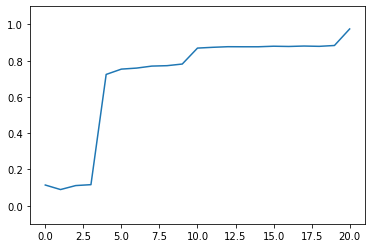

In [13]:
plt.ylim(-0.1, 1.1)
plot(network.valid_accuracy)

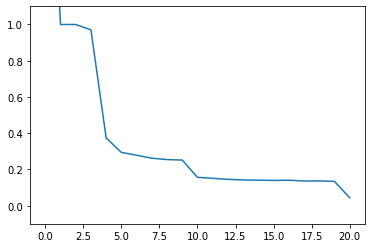

In [15]:
plt.ylim(-0.1, 1.1)
plot(network.valid_losses)